Import 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import random
import datetime

from tqdm import tqdm_notebook as tqdm

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import LabelEncoder

from sklearn import preprocessing


# Input data files are available in the "../input/" directory.

In [2]:
path = '../input/ashrae-energy-prediction'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/ashrae-energy-prediction/test.csv
../input/ashrae-energy-prediction/building_metadata.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/weather_train.csv


# Load data and display samples

In [3]:
%%time
# unimportant features 
unimportant_cols = ['wind_direction', 'wind_speed', 'sea_level_pressure']
target = 'meter_reading'

def load_data(source='train', path=path):
    ''' load and merge all tables '''
    assert source in ['train', 'test']
    
    building = pd.read_csv(f'{path}/building_metadata.csv', dtype={'building_id':np.uint16, 'site_id':np.uint8})
    weather  = pd.read_csv(f'{path}/weather_{source}.csv', parse_dates=['timestamp'],
                                                           dtype={'site_id':np.uint8, 'air_temperature':np.float16,
                                                                  'cloud_coverage':np.float16, 'dew_temperature':np.float16,
                                                                  'precip_depth_1_hr':np.float16},
                                                           usecols=lambda c: c not in unimportant_cols)
    df = pd.read_csv(f'{path}/{source}.csv', dtype={'building_id':np.uint16, 'meter':np.uint8}, parse_dates=['timestamp'])
    df = df.merge(building, on='building_id', how='left')
    df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
    return df

# load and display some samples
train = load_data('train')
train.sample(7)

CPU times: user 22.3 s, sys: 4.81 s, total: 27.1 s
Wall time: 27.2 s


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
12829041,990,0,2016-08-22 11:00:00,119.000,9,Office,82939,NaN,NaN,23.906250,NaN,23.296875,0.0
6129336,747,1,2016-04-25 00:00:00,0.000,6,Education,30531,NaN,NaN,19.406250,0.0,2.199219,0.0
4608350,910,0,2016-03-28 20:00:00,65.000,9,Office,60096,NaN,NaN,21.703125,2.0,5.000000,0.0
6548517,884,0,2016-05-02 11:00:00,98.000,9,Education,38598,NaN,NaN,17.796875,NaN,10.601562,0.0
12233923,33,0,2016-08-11 19:00:00,541.407,0,Lodging/residential,38686,2002.0,NaN,32.187500,NaN,22.203125,0.0
15584976,569,0,2016-10-10 09:00:00,314.250,4,Education,86091,1964.0,8.0,13.296875,4.0,11.703125,0.0
11681104,1295,0,2016-08-01 18:00:00,8.200,14,Office,115676,NaN,NaN,22.796875,NaN,20.593750,3.0


### Do thesame to Test data

In [4]:
test = load_data('test')
test.sample(7)

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
7584467,7584467,163,3,2018-09-03 15:00:00,2,Education,72102,1970.0,NaN,26.703125,2.0,18.296875,0.0
6468171,6468171,212,0,2018-03-26 16:00:00,2,Education,327256,2012.0,NaN,16.093750,2.0,-1.700195,0.0
15957913,15957913,676,0,2018-06-25 16:00:00,5,Manufacturing/industrial,90697,1976.0,2.0,27.000000,0.0,7.000000,NaN
25352597,25352597,1011,3,2017-10-12 03:00:00,10,Education,65144,NaN,4.0,13.898438,0.0,-3.900391,0.0
18385749,18385749,798,1,2018-11-04 17:00:00,7,Education,409028,1970.0,21.0,5.101562,NaN,-3.500000,NaN
40971752,40971752,1408,1,2018-10-03 22:00:00,15,Entertainment/public assembly,28760,2007.0,NaN,15.601562,NaN,12.796875,NaN
37427274,37427274,1417,0,2017-02-08 16:00:00,15,Lodging/residential,40451,1975.0,NaN,3.000000,NaN,-1.000000,NaN


## Function to reduce the DF size

In [5]:

def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
reduce_memory_usage(test)
reduce_memory_usage(train)

Mem. usage decreased to 1908.76 Mb (29.4% reduction)
Mem. usage decreased to 925.42 Mb (29.4% reduction)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0


# target's log-log histogram:

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

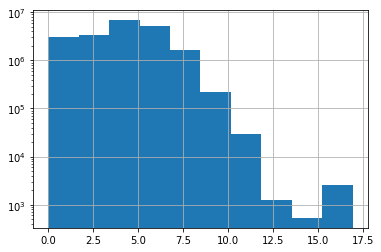

In [7]:

ax = np.log1p(train.meter_reading).hist()
ax.set_yscale('log')

# describe raw values first
train.meter_reading.describe()

# check the distribution in the types of meters

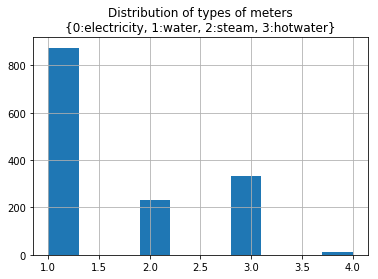

In [8]:

meters = train.groupby('building_id').meter.nunique()
plt.title('Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}') 
_ = meters.hist()


### display a single time series (notice measurement errors and discontinuities)

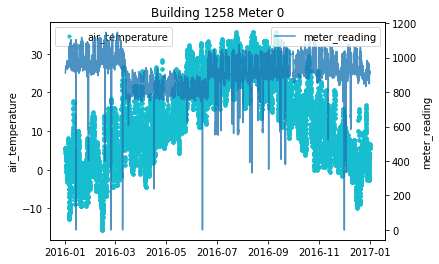

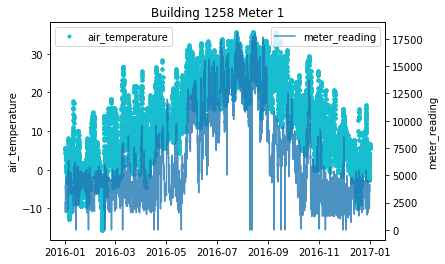

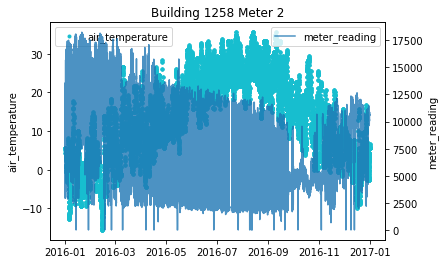

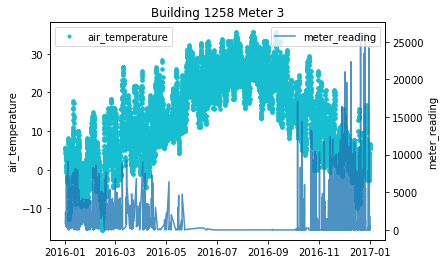

In [9]:
building_id = 1258  # a building with all 4 meters
meters = train[train['building_id'] == building_id].meter.nunique()

for meter in range(meters):
    fig, ax = plt.subplots()
    plt.title(f'Building {building_id} Meter {meter}')
    ax2 = ax.twinx()
    # plot meter_reading
    idx = (train['building_id'] == building_id) & (train['meter'] == meter)
    dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'])
    ax2.plot_date(dates, train.loc[idx, 'meter_reading'], '-', label='meter_reading', alpha=0.8)
    # plot air_temperature
    dates = matplotlib.dates.date2num(train.loc[train['building_id'] == building_id, 'timestamp'])
    ax.plot_date(dates, train.loc[train['building_id'] == building_id, 'air_temperature'], '.', color='tab:cyan', label='air_temperature')
    ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
    ax.legend(loc='upper left'); ax2.legend(loc='upper right')

### now let's see what's the expected prediction in the test set for the same building

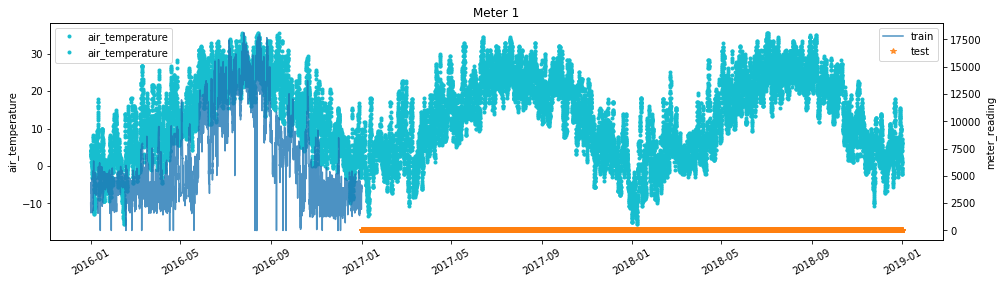

In [10]:
meter = 1 # pick a meter

train_sample = train[(train['building_id'] == building_id) & (train['meter'] == meter)]  # same train sample as above

test['meter_reading'] = 0.0
test_sample = test[(test['building_id'] == building_id) & (test['meter'] == meter)]  # and the same meter in the test set

fig, ax = plt.subplots(figsize=(16,4))
plt.title(f'Meter {meter}')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

# plot training sample
dates = matplotlib.dates.date2num(train_sample['timestamp'])
ax2.plot_date(dates, train_sample['meter_reading'], '-', label='train', alpha=0.8)
ax.plot_date(dates, train_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')

# plot test sample
dates = matplotlib.dates.date2num(test_sample['timestamp'])
ax2.plot_date(dates, test_sample['meter_reading'], '*', label='test', alpha=0.8)
ax.plot_date(dates, test_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')

ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')

del train_sample; del test_sample; del dates

In [11]:
# some feature stats
train.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8088455.0,3506933.0,2.011944e+07,11390735.0,2.011596e+07,16467077.0
mean,7.992780e+02,6.624412e-01,1.988706e+03,7.992232e+00,1.077830e+05,NaN,NaN,NaN,NaN,NaN,NaN
std,4.269133e+02,9.309921e-01,1.532159e+05,5.099060e+00,1.171424e+05,NaN,0.0,0.000000e+00,0.0,0.000000e+00,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1900.0,1.0,-2.890625e+01,0.0,-3.500000e+01,-1.0
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1951.0,1.0,8.601562e+00,0.0,0.000000e+00,0.0
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1969.0,3.0,1.670312e+01,0.0,8.898438e+00,0.0
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1993.0,6.0,2.409375e+01,4.0,1.609375e+01,0.0
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2017.0,26.0,4.718750e+01,9.0,2.609375e+01,343.0


# the counts above expose the missing data (Should we drop or refill the missing data?)

In [12]:

print("Ratio of available data (not NAN's):")
data_ratios = train.count()/len(train)
data_ratios

Ratio of available data (not NAN's):


building_id          1.000000
meter                1.000000
timestamp            1.000000
meter_reading        1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
year_built           0.400100
floor_count          0.173472
air_temperature      0.995219
cloud_coverage       0.563449
dew_temperature      0.995047
precip_depth_1_hr    0.814553
dtype: float64

# the same happening in the test set

In [13]:

print("Ratio of available data (not NAN's):")
test.count()/len(test)

Ratio of available data (not NAN's):


row_id               1.000000
building_id          1.000000
meter                1.000000
timestamp            1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
year_built           0.410084
floor_count          0.173950
air_temperature      0.994678
cloud_coverage       0.531336
dew_temperature      0.993745
precip_depth_1_hr    0.812901
meter_reading        1.000000
dtype: float64

# we can refill with averages(mean)

In [14]:

train.loc[:, data_ratios < 1.0].mean()

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


year_built           NaN
floor_count          NaN
air_temperature      NaN
cloud_coverage       0.0
dew_temperature      NaN
precip_depth_1_hr    NaN
dtype: float16

# Preprocess data
1. # refill NAN with averages
2. # expand datetime into its components
3. # Label encoding 
4. # remove redundant columns

In [15]:
class ASHRAE3Preprocessor(object):
    @classmethod
    def fit(cls, df, data_ratios=data_ratios):
        cls.avgs = df.loc[:,data_ratios < 1.0].mean()
        cls.pu_le = LabelEncoder()
        cls.pu_le.fit(df["primary_use"])

    @classmethod
    def transform(cls, df):
        df = df.fillna(cls.avgs) 
        df['primary_use'] = np.uint8(cls.pu_le.transform(df['primary_use']))  # encode labels
        df['hour'] = np.uint8(df['timestamp'].dt.hour)
        df['day'] = np.uint8(df['timestamp'].dt.day)
        df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
        df['month'] = np.uint8(df['timestamp'].dt.month)
        df['year'] = np.uint8(df['timestamp'].dt.year-2000)
        
        # parse and cast columns to a smaller type
        df.rename(columns={"square_feet": "log_square_feet"}, inplace=True)
        df['log_square_feet'] = np.float16(np.log(df['log_square_feet']))
        df['year_built'] = np.uint8(df['year_built']-1900)
        df['floor_count'] = np.uint8(df['floor_count'])
        
       
        for col in df.columns:
            if col in ['timestamp', 'row_id']:
                del df[col]
    
        # extract target column
        if 'meter_reading' in df.columns:
            df['meter_reading'] = np.log1p(df['meter_reading']).astype(np.float32) # comp metric uses log errors

        return df
        
ASHRAE3Preprocessor.fit(train)

In [16]:
train = ASHRAE3Preprocessor.transform(train)
train.sample(7)

,building_id,meter,meter_reading,site_id,primary_use,log_square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,day,weekday,month,year
7215452,1310,0,3.723281,14,4,10.953125,0,0,12.203125,2.0,11.703125,0.0,7,14,5,5,16
14653821,929,1,7.035506,9,0,12.203125,0,0,32.812500,0.0,22.203125,0.0,22,23,4,9,16
9039574,1410,1,3.921207,15,6,9.351562,94,0,25.593750,0.0,9.398438,NaN,17,15,2,6,16
16547329,324,0,2.908539,3,1,9.382812,0,0,10.601562,6.0,8.296875,0.0,12,27,3,10,16
5440255,208,1,4.149844,2,3,10.515625,34,0,23.296875,2.0,8.898438,0.0,18,12,1,4,16
7052659,834,0,3.378723,8,9,8.500000,0,1,21.703125,0.0,18.296875,0.0,10,11,2,5,16
10269550,1265,1,6.299247,14,2,10.476562,0,0,29.406250,0.0,21.703125,0.0,14,7,3,7,16


In [17]:
train.dtypes

building_id           uint16
meter                  uint8
meter_reading        float32
site_id                uint8
primary_use            uint8
log_square_feet      float16
year_built             uint8
floor_count            uint8
air_temperature      float16
cloud_coverage       float16
dew_temperature      float16
precip_depth_1_hr    float16
hour                   uint8
day                    uint8
weekday                uint8
month                  uint8
year                   uint8
dtype: object

In [18]:
print("Percentage of missing values in the train dataset")
train.isna().sum()/len(train)*100

Percentage of missing values in the train dataset


building_id           0.000000
meter                 0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
log_square_feet       0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.478124
cloud_coverage        0.000000
dew_temperature       0.495348
precip_depth_1_hr    18.544739
hour                  0.000000
day                   0.000000
weekday               0.000000
month                 0.000000
year                  0.000000
dtype: float64

# Displaying outliers

In [19]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(
        np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(
        np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [20]:
print("{} percent of {} are outliers."
      .format((
              (100 * outlier_function(train, 'meter_reading')[2])
               / len(train['meter_reading'])),
              'meter_reading'))

0.015571747270739658 percent of meter_reading are outliers.


Text(0.5, 1.0, 'Density of Logartihm(Meter Reading + 1) Among Different Meters')

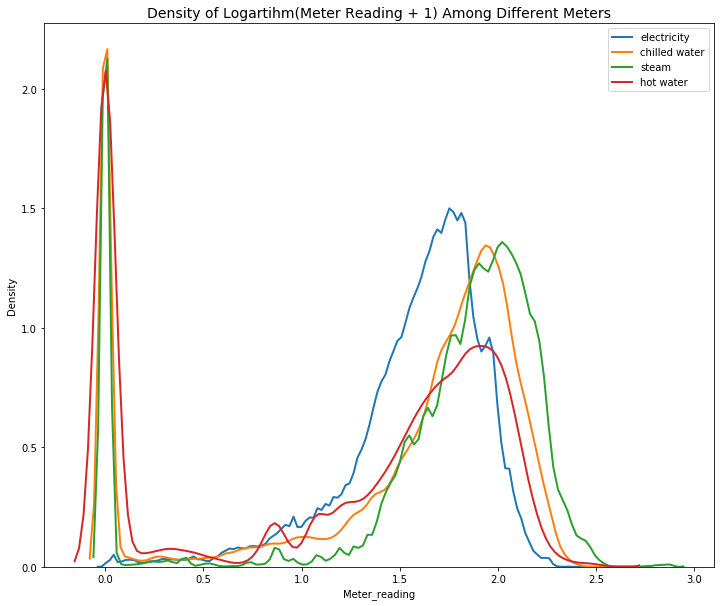

In [21]:
# Distribution of the meter reading in meters without zeros
plt.figure(figsize=(12,10))

#list of different meters
meters = sorted(train['meter'].unique().tolist()) # [0, 1, 2, 3]

# plot meter_reading distribution for each meter
for meter_type in meters:
    subset = train[train['meter'] == meter_type]
    sns.kdeplot(np.log1p(subset["meter_reading"]), 
                label=meter_type, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Meter_reading")
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
plt.title("Density of Logartihm(Meter Reading + 1) Among Different Meters", size=14)

# Feature ranked correlation

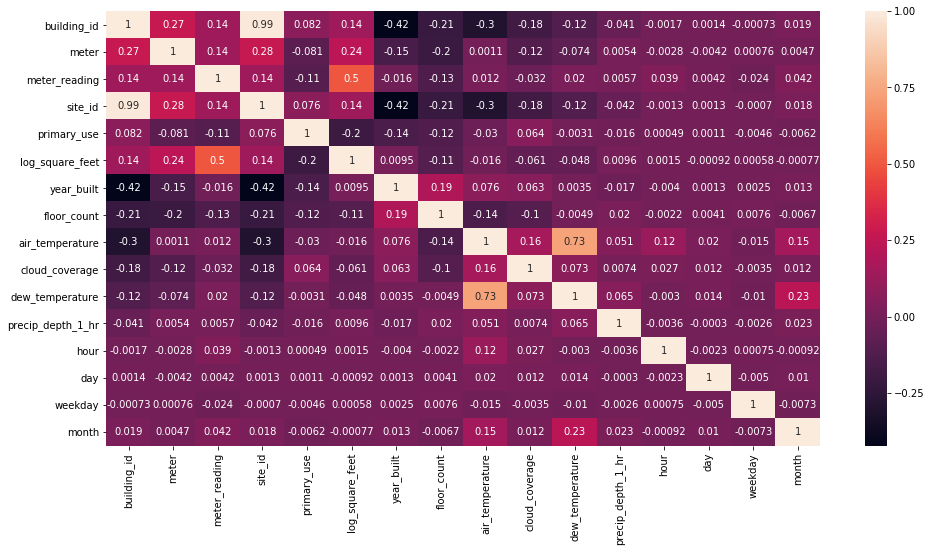

In [22]:

fig, ax = plt.subplots(figsize=(16,8))
# use a ranked correlation to catch nonlinearities
corr = train[[col for col in train.columns if col != 'year']].sample(100100).corr(method='spearman')
_ = sns.heatmap(corr, annot=True,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

# Deep learning trainig
* Splitting data

In [23]:
X = train[['meter', 'building_id', 'primary_use', 'month', 'day','air_temperature','log_square_feet','floor_count', 'precip_depth_1_hr', 'cloud_coverage']]
y = train['meter_reading']

In [24]:
from sklearn.model_selection  import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state= 45)

In [25]:
from sklearn import preprocessing
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras import regularizers

Using TensorFlow backend.


In [26]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Defining LSTM model

In [27]:
def make_model(input_dim=10,metrics=root_mean_squared_error,loss='mse', optimizer="rmsprop",drop_rate=0.5):

  model = Sequential()
  model.add(LSTM(128,return_sequences=True, input_shape=(None,input_dim)))
  model.add(Dropout(drop_rate))
  model.add(BatchNormalization())
  model.add(LSTM(128,return_sequences=False))
  model.add(BatchNormalization())
  model.add(Dropout(drop_rate))
  model.add(Dense(1))
  model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
  
  return model

In [28]:
def run_model(model,x_train,y_train,epochs=50,batch_size=500,verbose=1,validation_data=(x_val,y_val),callbacks =None):
  x_train = x_train.values[:]
  x_train= x_train.reshape((x_train.shape[0],1,x_train.shape[-1]))
  y_train = np.log1p(y_train)
  if validation_data != None:
    x_val = validation_data[0].values[:]
    x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[-1]))
    y_val = np.log1p(validation_data[-1])
      
  return model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_data=(x_val,y_val),callbacks=callbacks)

In [29]:
em = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0001, patience=5, verbose=True, mode='auto')

In [30]:
model = make_model(input_dim=x_train.shape[-1],drop_rate=0.2)

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         71168     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [32]:
history = run_model(model,x_train,y_train,epochs=1,batch_size=500,verbose=1,validation_data=(x_val,y_val), callbacks =[em]) 

Train on 16172880 samples, validate on 4043220 samples
Epoch 1/1
16172880/16172880 [==============================] - 832s 51us/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan


In [33]:
loss = history.history
loss.keys()

dict_keys(['val_loss', 'val_root_mean_squared_error', 'loss', 'root_mean_squared_error'])

#rmse loss

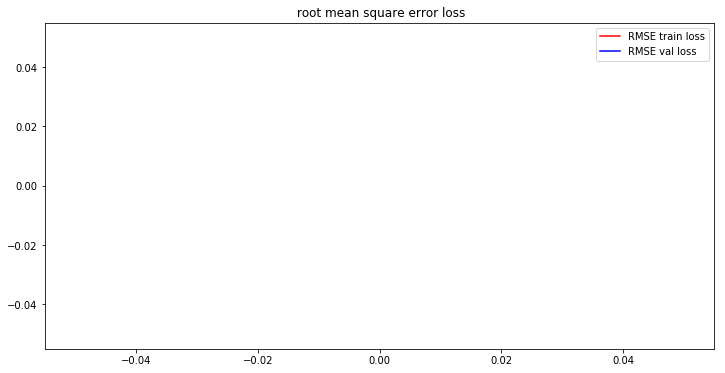

In [35]:

rmse_loss_train = loss['root_mean_squared_error']
rmse_loss_val = loss['val_root_mean_squared_error']
epochs_stops = em.stopped_epoch +1 # epochs number from early stopping
epochs = range(1,epochs_stops + 1)  #len(loss_train)
plt.figure(figsize=(12,6))
plt.plot(epochs,rmse_loss_train,'r', label='RMSE train loss')
plt.plot(epochs,rmse_loss_val,'b',label='RMSE val loss')
plt.title(' root mean square error loss')
plt.legend()
plt.show()

# Check prediction

# load and pre-process test data

In [37]:

test = ASHRAE3Preprocessor.transform(test)
test.sample(7)

,building_id,meter,site_id,primary_use,log_square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,meter_reading,hour,day,weekday,month,year
19345551,869,0,8,1,13.679688,0,1,31.703125,0.0,24.406250,0.0,0.0,20,25,0,6,18
3631735,254,1,2,1,12.445312,89,0,19.406250,4.0,7.800781,0.0,0.0,17,10,4,2,17
34920056,1257,0,14,6,11.023438,0,0,1.700195,2.0,0.600098,0.0,0.0,7,5,0,2,18
11485768,441,0,3,9,8.093750,0,0,16.093750,0.0,6.699219,0.0,0.0,10,13,4,4,18
36991622,1250,2,14,0,12.351562,0,0,5.000000,0.0,3.900391,0.0,0.0,2,2,6,12,18
30335257,1074,0,13,6,11.406250,0,0,22.796875,0.0,10.000000,0.0,0.0,19,30,0,4,18
2774405,149,0,1,6,11.312500,60,8,11.398438,0.0,10.703125,NaN,0.0,10,7,3,12,17


# Test Inference and Submission

In [38]:
# split test data into batches
set_size = len(test)
iterations = 50
batch_size = set_size // iterations

print(set_size, iterations, batch_size)
assert set_size == iterations * batch_size

41697600 50 833952


In [39]:
submit = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')

In [40]:
 x_test = test[['meter', 'building_id', 'primary_use', 'month', 'day','air_temperature','log_square_feet','floor_count', 'precip_depth_1_hr', 'cloud_coverage']]
 x_test = x_test.values[:]
 x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[-1]))

In [ ]:
prediction = model.predict(x_test)

### Save submission

In [ ]:
submit['meter_reading'] = prediction

In [ ]:
submit.to_csv('submission.csv', index=False,float_format='%.4f')